In [133]:
import numpy as np
import math
from scipy import integrate as INT
from scipy.signal import convolve2d
import matplotlib.pyplot as plt
import pandas as pd
import cv2
import json
%matplotlib inline

In [134]:
noise_layers = {
    "train": {'cols':["TFLDIA", "TFLVES", "TFLNIT", "TFLDEN"], 
              'mainkey': "TFLDEN" },
    "airplane": {"cols": ["TALDIA", "TALVES", "TALNIT", "TALDEN"],
                'mainkey': "TALDEN" },
    "industrial": {"cols": [ "INLDIA", "INLVES", "INLNIT", "INLDEN"],
                'mainkey': "INLDEN"},
    "traffic": {"cols": ["TOTDIA", "TOTVES", "TOTNIT", "TOTDEN"] ,
                'mainkey': "TOTDEN"},
    "viario": {"cols": ["TVLDIA", "TVLVES", "TVLNIT", "TVLDEN"],
                'mainkey': "TVLDEN" },
    "total": {"cols": [],
                'mainkey': "" }
}

In [136]:
noise_columns = [col for layer in noise_layers.keys() for col in noise_layers[layer]['cols'][:-1] ]
noise_columns

['INLDIA',
 'INLVES',
 'INLNIT',
 'TFLDIA',
 'TFLVES',
 'TFLNIT',
 'TVLDIA',
 'TVLVES',
 'TVLNIT',
 'TOTDIA',
 'TOTVES',
 'TOTNIT',
 'TALDIA',
 'TALVES',
 'TALNIT']

In [137]:
cell_w=6.75925925926 #7.87037037037 #10.625
cell_h=cell_w
xy_ratio=cell_w/cell_h
#threshold of human ear, in Watts/(sm^2)
threshold = 1.0e-12
#Radius of sources in METERS, assume nothing is smaller than this
sourceRadius = 1.0
#Typical length of unit cell in METERS
unitLength = math.sqrt(cell_w*cell_h) 
# Distance at which we assume noise is blocked completely in METERS
blockDistance = 10
#longest distance at which we have some hearable noise
checkRange = 1000


In [138]:
def dBfromIntensity(intensity):
    return 10.0*np.log10(intensity/threshold)
def intensityFromdB(dB):
    return threshold*np.power(10.0,dB/10)

In [139]:
#helper functions to compute average distance to source
def intFunc(y,x):
    dist = (x*x+y*y*xy_ratio)
    if (dist<sourceRadius):
        return xy_ratio
    else:
        return xy_ratio/dist

def avgIntensity(nx,ny):
    return INT.dblquad(intFunc, nx-0.5, nx+0.5, lambda x: ny-0.5,lambda x:ny+0.5)[0]/(math.pow(unitLength,2))

In [147]:
info = {}
xWidth = 1920
def kernelize_layer(layer,fname=None):
    #This is the grid with the value of the sources (in dB)
    if (fname == None):
        sourceMap=pd.read_csv("./"+str(xWidth)+"_noise_level_"+layer+".csv",header=None).values
    else:
        referenceFile = "./"+str(xWidth)+"_noise_level_"+layer+".csv"
        Delta=pd.read_csv(fname,header=None).values
        meanDelta = Delta.mean()
        Reference=pd.read_csv(referenceFile,header=None).values
        zeroNoise=np.zeros(Reference.shape)
        Reference=np.where(Reference>0,Reference+meanDelta,zeroNoise)
        Delta = np.where(Delta!=0,Delta-meanDelta,zeroNoise)
        sourceMap = np.where(Reference>0,Reference+2*Delta,zeroNoise)
        #np.maximum(Reference+2*Delta,zeroNoise) #dBfromIntensity(np.where(Reference>0,(intensityFromdB(Reference)+intensityFromdB(Delta)),zeroNoise))
    layer_max = sourceMap.max()
    layer_min = sourceMap[sourceMap>0.0].min()
    info[layer]={"max": layer_max, "min": layer_min}    
    #cv2.imwrite("original_"+layer+".png",255*(sourceMap)/(layer_max))
    #dimensions of the grid
    dimensionX = sourceMap.shape[0]
    dimensionY = sourceMap.shape[1]
    #We will check the longest distance at which we have some hearable noise
    intensityMap = intensityFromdB(sourceMap)
    meanIntensity = intensityMap.mean()
    oneDimRule = np.zeros(checkRange)
    zeroDist = avgIntensity(0,0)
    for nx in range(checkRange):
        intensity = avgIntensity(nx,0)
        oneDimRule[nx]= meanIntensity*intensity
    maxKernelRange = 3 #1+min(len(oneDimRule[oneDimRule>threshold*1]),int(math.floor(blockDistance/unitLength)))
    #print ("Kernel range is "+str(maxKernelRange))
    #maxKernelRange = len(oneDimRule[oneDimRule>threshold*1])
    #maxKernelRange=len(oneDimRule[oneDimRule>threshold*1])
    vectorizedKernel=np.zeros((maxKernelRange+1)*(maxKernelRange+2)/2)
    for nx in range(maxKernelRange+1):
        for ny in range(nx+1):
            iloc = ny*maxKernelRange-ny*(ny+1)/2+nx
            vectorizedKernel[iloc]= avgIntensity(nx,ny)            
    kernel = np.zeros((2*maxKernelRange+1,2*maxKernelRange+1))
    for ny in range(2*maxKernelRange+1):
        for nx in range(2*maxKernelRange+1):
            i=abs(nx-maxKernelRange)
            j=abs(ny-maxKernelRange)
            if (i>=j):
                iloc = j*maxKernelRange-j*(j+1)/2+i
            else:
                iloc = i*maxKernelRange-i*(i+1)/2+j        
            kernel[nx,ny]=vectorizedKernel[iloc]       
    #this will be the output of everything, in dB
    #We get the max between our calculation and the point source levels
    return np.maximum(sourceMap,dBfromIntensity(convolve2d(intensityMap,kernel ,mode='same')))

In [ ]:
# Hourly layers
hourlys={}
for hour in range(24):
    print (hour)
    filename = str(xWidth)+"_hourly_"+str(hour)+"_viario"+".csv"
    if (hour>=7 and hour < 21):
        in_name = "TVLDIA"
    elif (hour>=21 and hour <23):
        in_name = "TVLVES"
    else:
        in_name = "TVLNIT"
    hourlys[hour] = kernelize_layer(in_name,fname=filename)
    if (hour>0):
        print ("mean change: "+str((hourlys[hour]-hourlys[hour-1])[hourlys[hour]>0].mean()))
    df=pd.DataFrame(hourlys[hour].T)
    df.to_csv(str(xWidth)+"_noise_kernelized_hourly_"+str(hour)+"_viario.csv",header=False,index=False)    

0
1
mean change: -0.0214512240482
2
mean change: -0.0149578332194
3
mean change: -0.00448588785439
4
mean change: -0.00411899651323
5
mean change: 0.0120999726124
6
mean change: 0.0356368071365
7
mean change: 7.4442444581
8
mean change: 0.0428646180721
9
mean change: 0.0216643649196
10
mean change: -0.00526370910894
11
mean change: 0.0082269995276
12
mean change: 0.00543955634103
13
mean change: -0.00644465996084
14
mean change: -0.00608484574508
15
mean change: -0.0154144084779
16
mean change: 0.0189863886433
17
mean change: 0.0172760067688

In [156]:
for hour in range(24):
    print(hourlys[hour].mean())
info

1.60546737166
1.60273334743
1.60065847157
1.60014848073
1.59952771205
1.60107295682
1.60602296318
1.89130463056
1.89623428245
1.89910078402
1.89896112909
1.90026750275
1.90087326466
1.90011146041
1.89943784988
1.89745969321
1.8997380955
1.90189703926
1.90189309349
1.90161131963
1.89930746718
1.83459204451
1.82652893427
1.60773746778


{'TFLDIA': {'max': 70.462030504444996, 'min': 3.0400989389949991},
 'TFLNIT': {'max': 61.022409756702146, 'min': 3.0224028736421436},
 'TFLVES': {'max': 67.027216622183715, 'min': 3.0272148932237144}}

In [143]:
translate = {'INL': "Industrial", "TFL": "Train", "TVL": "Viario"}
moments = ["DIA", "VES", "NIT"]
usable_columns = {}
for beg in translate:
    for ending in moments:
        usable_columns[beg+ending]=translate[beg]+"_"+ending
usable_columns        

{'INLDIA': 'Industrial_DIA',
 'INLNIT': 'Industrial_NIT',
 'INLVES': 'Industrial_VES',
 'TFLDIA': 'Train_DIA',
 'TFLNIT': 'Train_NIT',
 'TFLVES': 'Train_VES',
 'TVLDIA': 'Viario_DIA',
 'TVLNIT': 'Viario_NIT',
 'TVLVES': 'Viario_VES'}

In [144]:
# Standard, do all layers
noiseMap={}
for layer in usable_columns:
    print(layer)
    noiseMap[layer] = kernelize_layer(layer)
    df=pd.DataFrame(noiseMap[layer].T)
    df.to_csv(str(xWidth)+"_noise_kernelized_"+usable_columns[layer]+".csv",header=False,index=False)        

TFLNIT
TFLDIA
INLVES
TVLVES
INLDIA
TVLNIT
INLNIT
TVLDIA
TFLVES


In [122]:
delta=pd.read_csv(str(xWidth)+"_hourly_"+str(10)+"_viario"+".csv",header=None).values
reference=pd.read_csv("./"+str(xWidth)+"_noise_level_"+"viario"+".csv",header=None).values
zeros=np.zeros(reference.shape)
mezcla = np.maximum(reference+delta,zeros)

In [123]:
reference[200,:].mean()

5.9131435080984627

In [124]:
delta[200,:].mean()

0.0013398552697211114

In [125]:
mezcla[200,:].mean()

5.9173993864969798

In [58]:
for layer in noise_layers:
    cv2.imwrite("temp_"+layer+".png",255*(noiseMap[layer].T)/(layer_max))
fo=open("map_infos.json",'w')
fo.write(json.dumps(info))
fo.close()
info

{'airplane': {'max': 9.0308998699200007, 'min': 3.0102999566400004},
 'industrial': {'max': 79.013740200100003, 'min': 3.0102999566400004},
 'total': {'max': 87.865880142600005, 'min': 6.9897000433600009},
 'traffic': {'max': 84.855580079500001, 'min': 3.0102999566400004},
 'train': {'max': 69.010301047499993, 'min': 3.0102999566400004},
 'viario': {'max': 84.855580079500001, 'min': 3.0102999566400004}}

In [59]:
# str(grid_width)+"_hourly_"+str(hour).zfill(2)+"_viario"+".csv"
for layer in noise_layers:
    df=pd.DataFrame(noiseMap[layer].T)
    df.to_csv(str(xWidth)+"_noise_kernelized_"+layer+".csv",header=False,index=False)

In [19]:
info

{'viario': {'max': 6.1819240287500001, 'min': 3.8616453030400001e-17}}

0


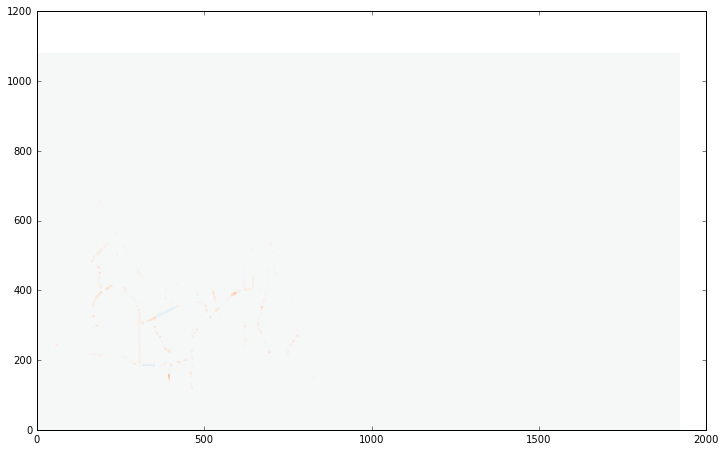

1


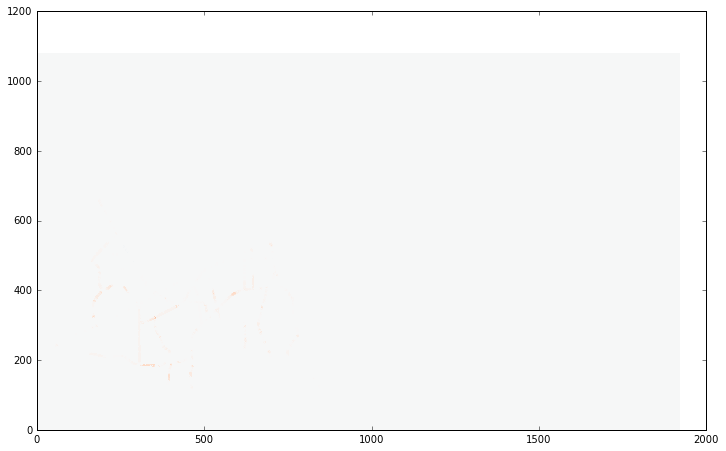

2


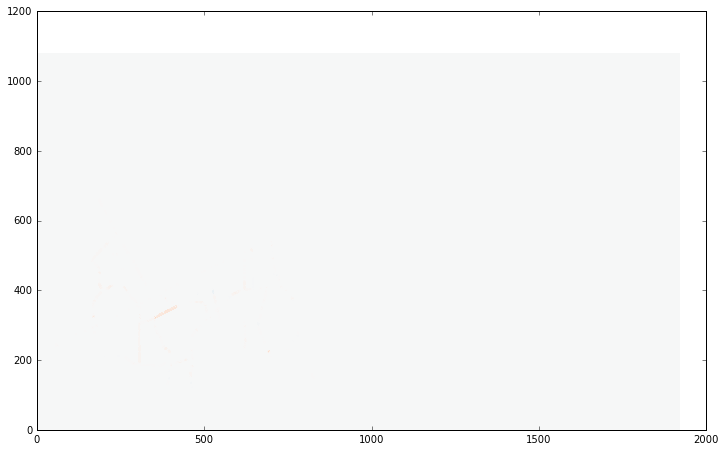

3


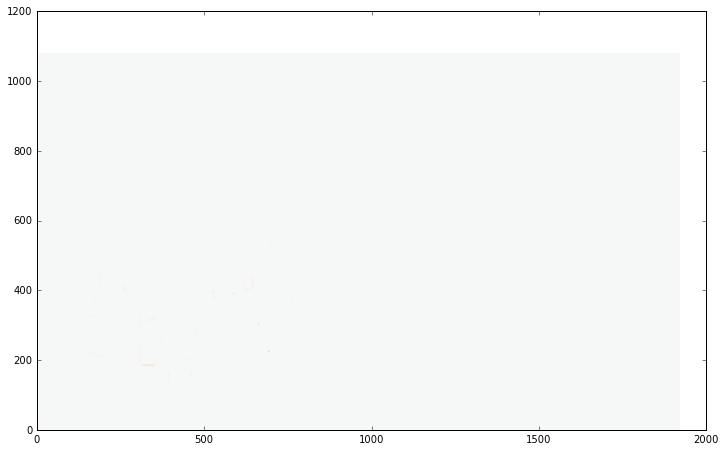

4


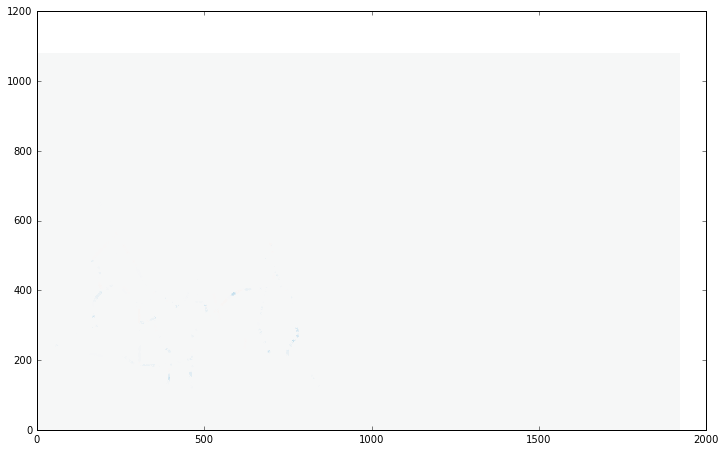

5


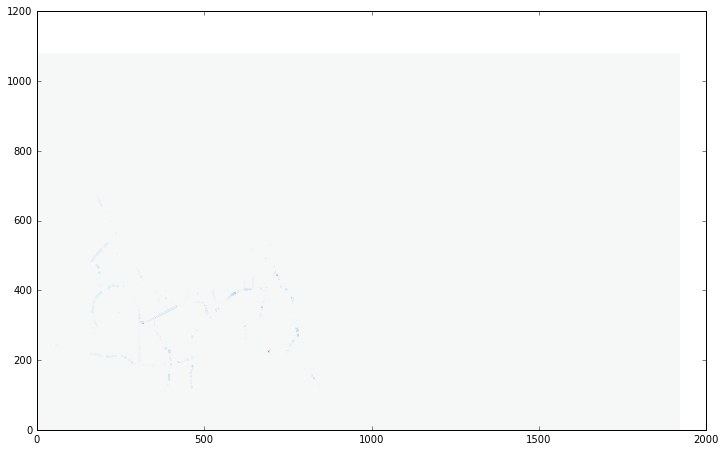

6


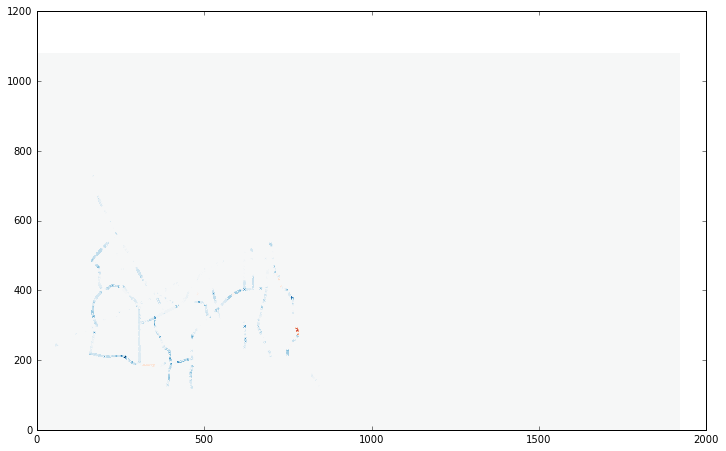

7


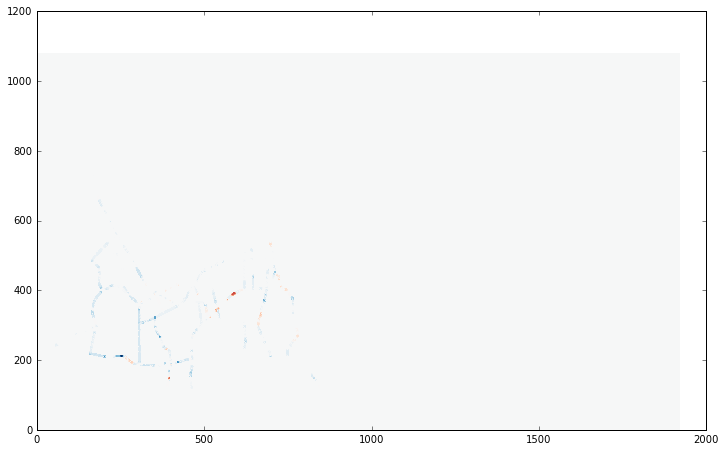

8


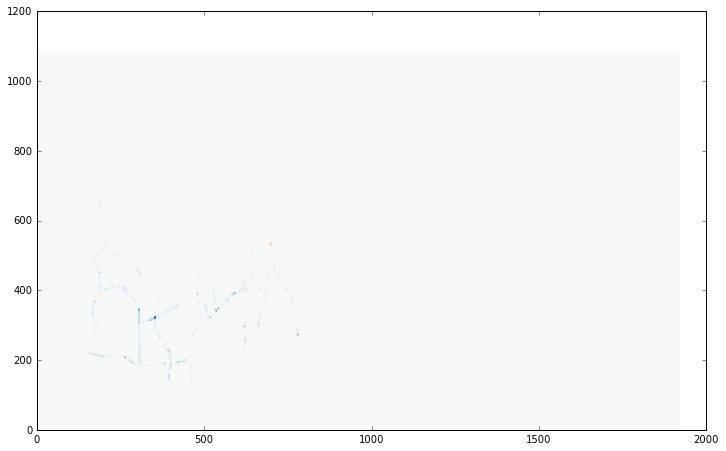

9


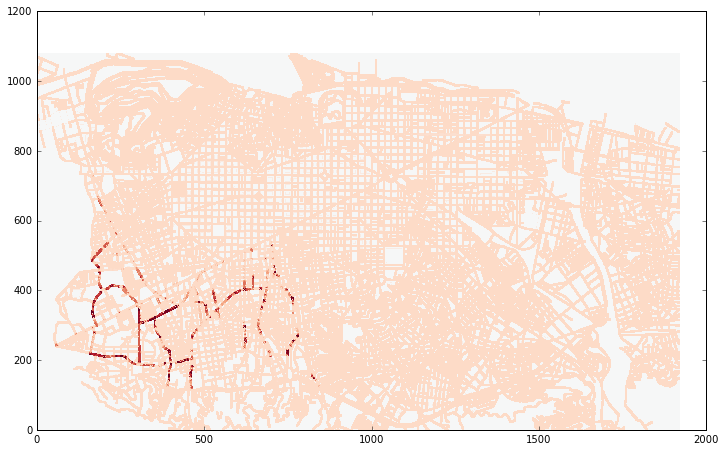

10


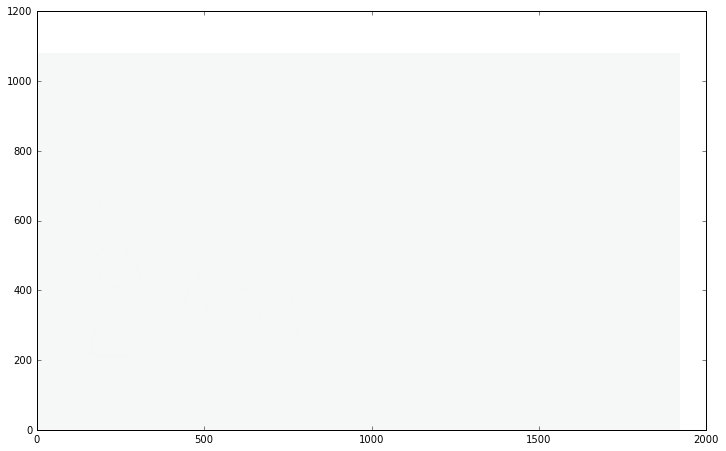

11


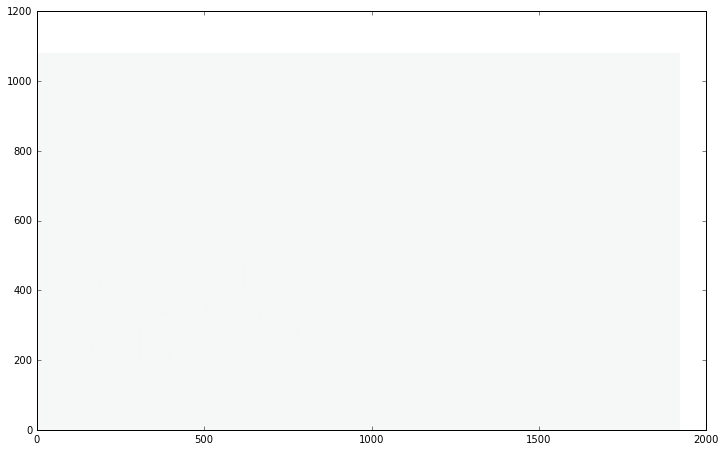

12


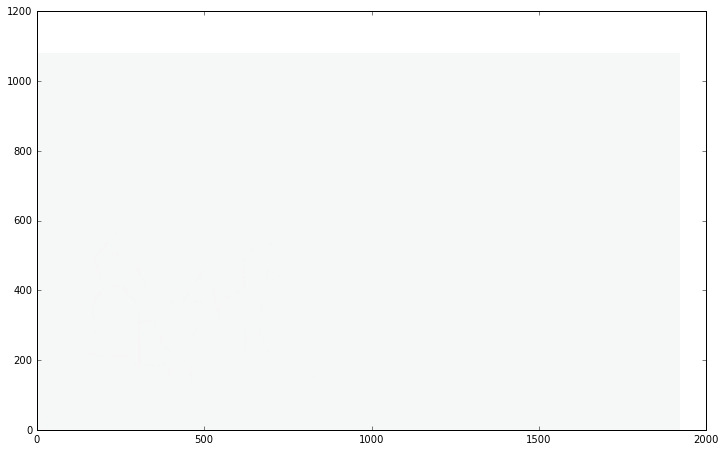

13


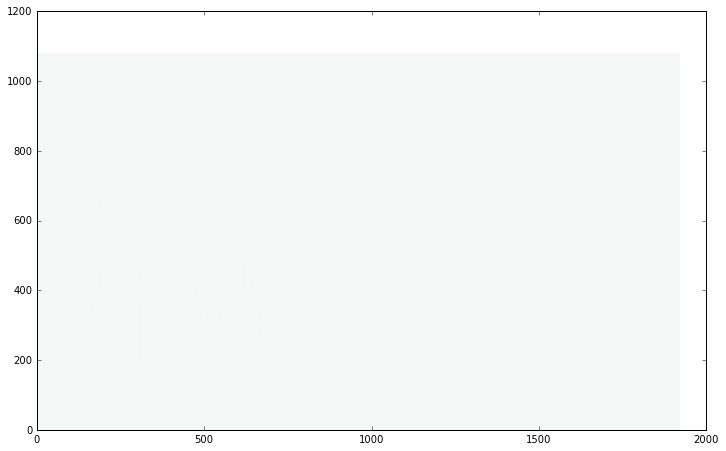

14


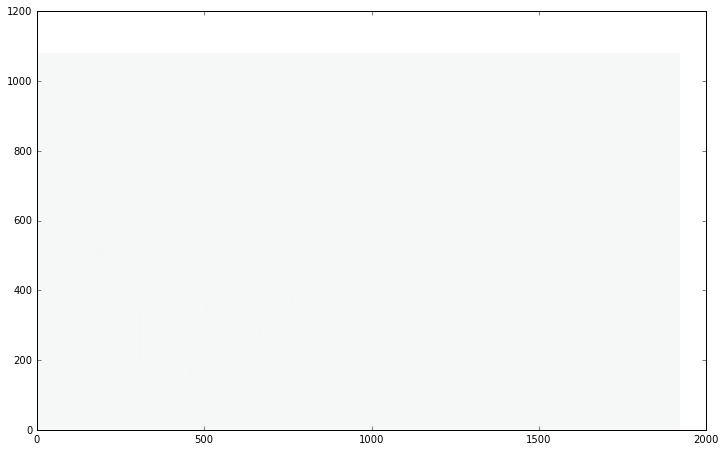

15


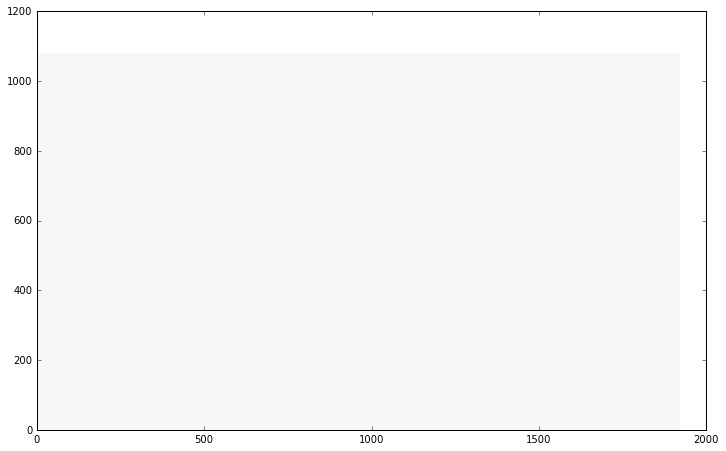

16


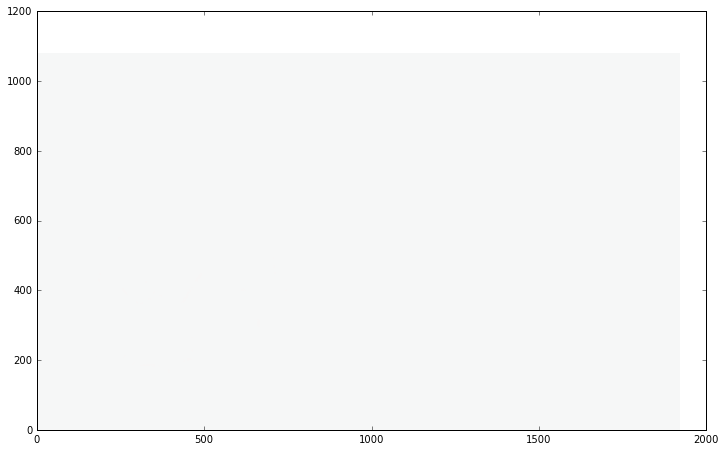

17


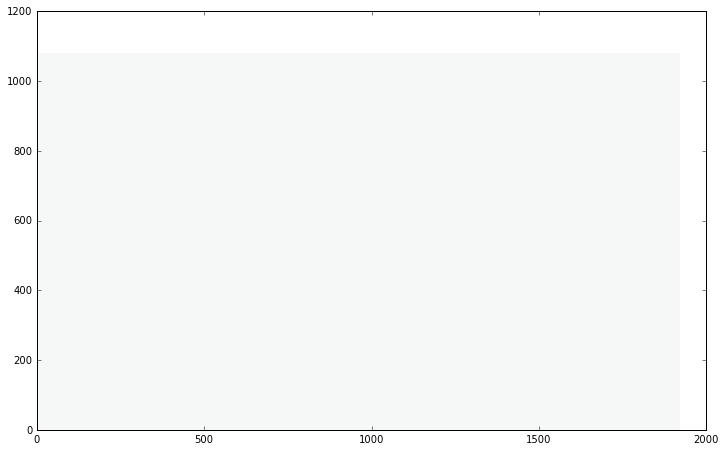

18


KeyboardInterrupt: 

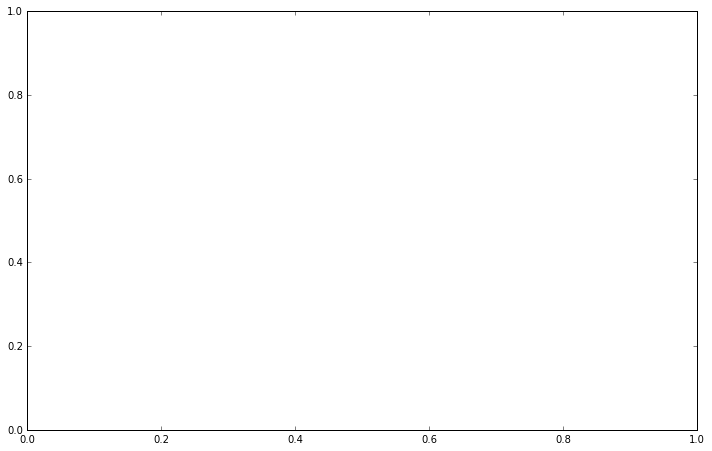

In [58]:
for hour in range(23):
    plt.figure(figsize=(16*0.75,10*0.75))
    print(hour)
    plt.pcolor((hourlys[hour+1]-hourlys[hour]).T,cmap='RdBu', vmin=-15, vmax=15)
    plt.show()

In [62]:
(hourlys[10+1]-hourlys[0]).min()

-2.0648138985279729e-06

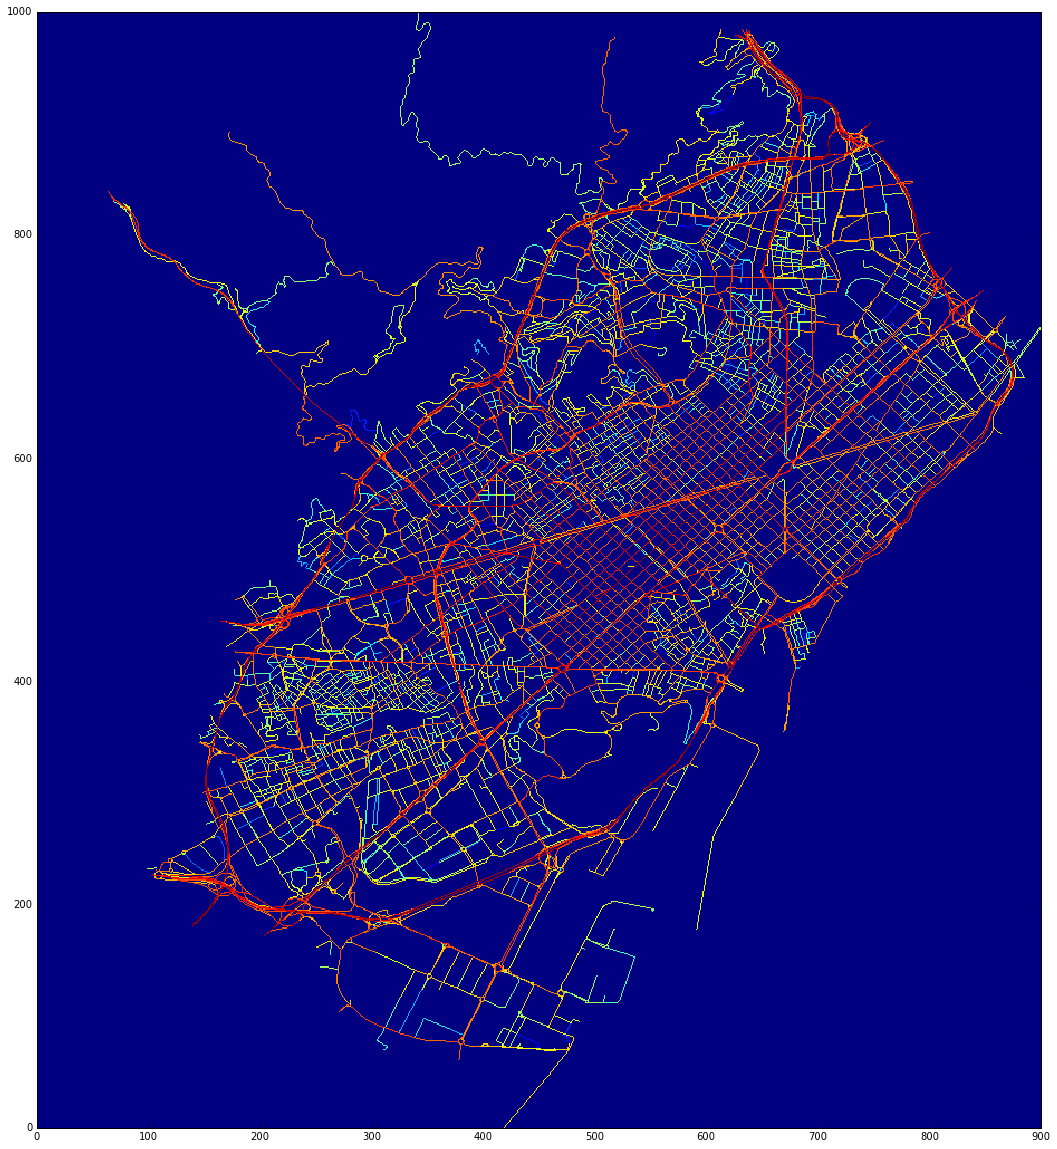

In [379]:
plt.figure(figsize=(18,20))
plt.pcolor(((sourceMap.T)))
plt.show()

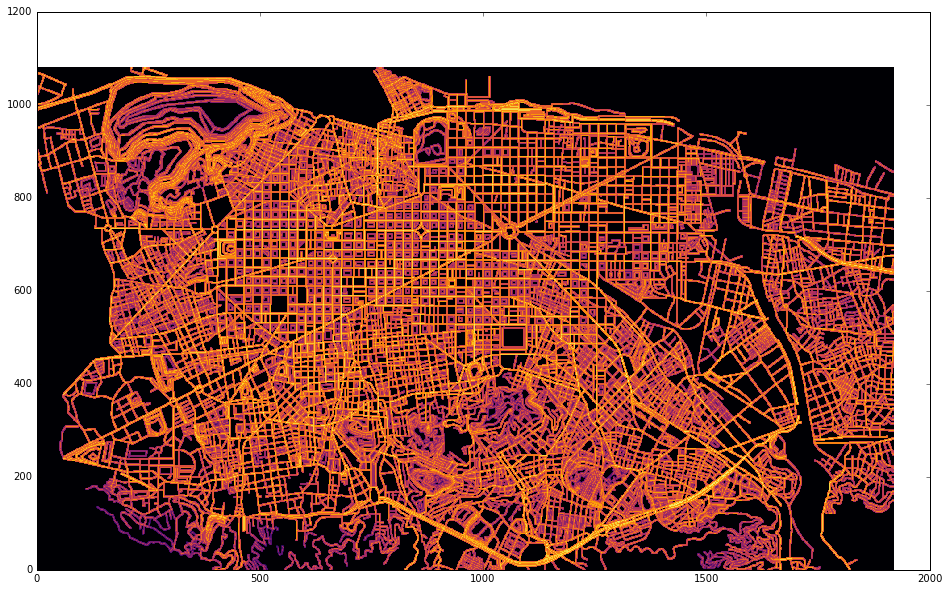

In [62]:
plt.figure(figsize=(16,10))
plt.pcolor(noiseMap["traffic"].T,cmap='inferno')
plt.show()

84.422292672859655

In [410]:
traficNoise = pd.DataFrame(noiseMap.T)
traficNoise.to_csv("traficNoise.csv",header=False,index=False)

In [66]:
total = noiseMap["viario"]+noiseMap["train"]+noiseMap["industrial"]

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x1e9a37e50>]], dtype=object)

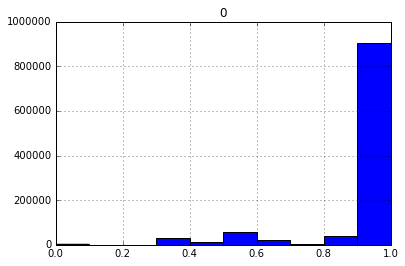

In [67]:
Hviario = (noiseMap["viario"]/total).flatten()
pd.DataFrame(Hviario).hist()

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x1e95d11d0>]], dtype=object)

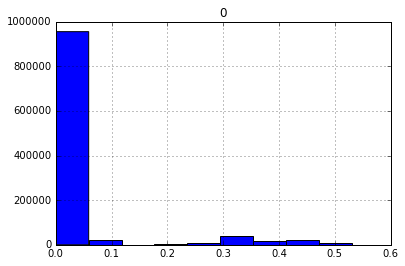

In [68]:
Htrain = (noiseMap["train"]/total).flatten()
pd.DataFrame(Htrain).hist()

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x12bcb0190>]], dtype=object)

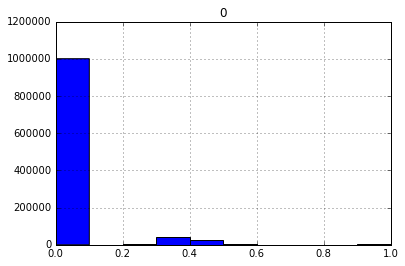

In [69]:
Hind = (noiseMap["industrial"]/total).flatten()
pd.DataFrame(Hind).hist()